<!--NAVIGATION-->
< [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb) | [Contents](Index.ipynb) | [Vectorized String Operations](03.10-Working-With-Strings.ipynb) >


# Pivot Tables

We have seen how the ``GroupBy`` abstraction lets us explore relationships within a dataset.
A *pivot table* is a similar operation that is commonly seen in spreadsheets and other programs that operate on tabular data.
The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data.
The difference between pivot tables and ``GroupBy`` can sometimes cause confusion; it helps me to think of pivot tables as essentially a *multidimensional* version of ``GroupBy`` aggregation.
That is, you split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

## Motivating Pivot Tables

For the examples in this section, we'll use the database of passengers on the *Titanic*, available through the Seaborn library (see [Visualization With Seaborn](04.14-Visualization-With-Seaborn.ipynb)):

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
titanic = sns.load_dataset('titanic')

In [4]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [5]:
titanic.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')

In [6]:
titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


This contains a wealth of information on each passenger of that ill-fated voyage, including gender, age, class, fare paid, and much more.

## Pivot Tables by Hand

To start learning more about this data, we might begin by grouping according to gender, survival status, or some combination thereof.
If you have read the previous section, you might be tempted to apply a ``GroupBy`` operation–for example, let's look at survival rate by gender:

In [7]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


In [8]:
titanic.groupby('sex')[['survived']].sum()

,survived
sex,
female,233
male,109


In [9]:
titanic.shape

(891, 15)

This immediately gives us some insight: overall, three of every four females on board survived, while only one in five males survived!

This is useful, but we might like to go one step deeper and look at survival by both sex and, say, class.
Using the vocabulary of ``GroupBy``, we might proceed using something like this:
we *group by* class and gender, *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and then *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

In [10]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


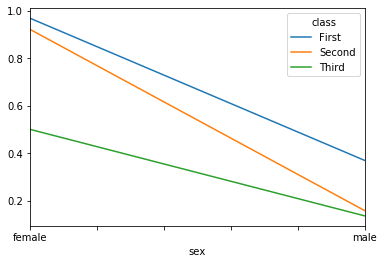

In [11]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack().plot()

This gives us a better idea of how both gender and class affected survival, but the code is starting to look a bit garbled.
While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use.
This two-dimensional ``GroupBy`` is common enough that Pandas includes a convenience routine, ``pivot_table``, which succinctly handles this type of multi-dimensional aggregation.

## Pivot Table Syntax

Here is the equivalent to the preceding operation using the ``pivot_table`` method of ``DataFrame``s:

In [12]:
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This is eminently more readable than the ``groupby`` approach, and produces the same result.
As you might expect of an early 20th-century transatlantic cruise, the survival gradient favors both women and higher classes.
First-class women survived with near certainty (hi, Rose!), while only one in ten third-class men survived (sorry, Jack!).

### Multi-level pivot tables

Just as in the ``GroupBy``, the grouping in pivot tables can be specified with multiple levels, and via a number of options.
For example, we might be interested in looking at age as a third dimension.
We'll bin the age using the ``pd.cut`` function:

In [13]:
age = pd.cut(titanic['age'], [0, 18, 30,50, 80])
titanic.pivot_table('survived', ['sex', age], 'class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 30]  0.958333  0.900000  0.500000
       (30, 50]  0.972973  0.925926  0.272727
       (50, 80]  1.000000  0.666667  1.000000
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 30]  0.428571  0.027027  0.147541
       (30, 50]  0.448980  0.114286  0.126761
       (50, 80]  0.192308  0.083333  0.000000

We can apply the same strategy when working with the columns as well; let's add info on the fare paid using ``pd.qcut`` to automatically compute quantiles:

In [14]:
fare = pd.qcut(titanic['fare'], 3)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 8.662]           (8.662, 26.0]                      \
class                     First     Third         First    Second     Third   
sex    age                                                                    
female (0, 18]              NaN  0.700000           NaN  1.000000  0.583333   
       (18, 30]             NaN  0.611111           NaN  0.880000  0.411765   
       (30, 50]             NaN  0.000000           1.0  0.904762  0.416667   
       (50, 80]             NaN       NaN           NaN  0.666667  1.000000   
male   (0, 18]              NaN  0.166667           NaN  0.500000  0.500000   
       (18, 30]             NaN  0.139785           NaN  0.033333  0.148148   
       (30, 50]             0.0  0.127273           0.0  0.142857  0.000000   
       (50, 80]             NaN  0.000000           0.0  0.090909       NaN   

fare            (26.0, 512.329]                   
class                     First Second     Third  
sex    age                                        
female (0, 18]         0.909091    1.0  0.111111  
       (18, 30]        0.958333    1.0  0.000000  
       (30, 50]        0.971429    1.0  0.142857  
       (50, 80]        1.000000    NaN       NaN  
male   (0, 18]         0.800000    0.8  0.052632  
       (18, 30]        0.428571    0.0  0.500000  
       (30, 50]        0.500000    0.0  0.500000  
       (50, 80]        0.200000    0.0       NaN

The result is a four-dimensional aggregation with hierarchical indices (see [Hierarchical Indexing](03.05-Hierarchical-Indexing.ipynb)), shown in a grid demonstrating the relationship between the values.

### Additional pivot table options

The full call signature of the ``pivot_table`` method of ``DataFrame``s is as follows:

```python
# call signature as of Pandas 0.18
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All')
```

We've already seen examples of the first three arguments; here we'll take a quick look at the remaining ones.
Two of the options, ``fill_value`` and ``dropna``, have to do with missing data and are fairly straightforward; we will not show examples of them here.

The ``aggfunc`` keyword controls what type of aggregation is applied, which is a mean by default.
As in the GroupBy, the aggregation specification can be a string representing one of several common choices (e.g., ``'sum'``, ``'mean'``, ``'count'``, ``'min'``, ``'max'``, etc.) or a function that implements an aggregation (e.g., ``np.sum()``, ``min()``, ``sum()``, etc.).
Additionally, it can be specified as a dictionary mapping a column to any of the above desired options:

In [15]:
titanic.pivot_table(index='sex', columns='class',
                   aggfunc={'survived':sum, 'fare':'mean','alive':'count'})

alive                     fare                       survived         \
class  First Second Third       First     Second      Third    First Second   
sex                                                                           
female    94     76   144  106.125798  21.970121  16.118810       91     70   
male     122    108   347   67.226127  19.741782  12.661633       45     17   

              
class  Third  
sex           
female    72  
male      47

Notice also here that we've omitted the ``values`` keyword; when specifying a mapping for ``aggfunc``, this is determined automatically.

At times it's useful to compute totals along each grouping.
This can be done via the ``margins`` keyword:

In [16]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True)

class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


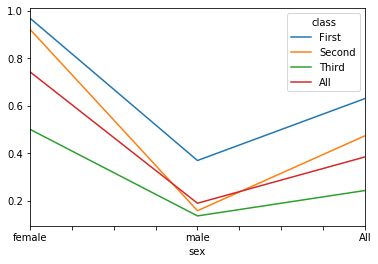

In [17]:
titanic.pivot_table('survived', index='sex', columns='class', margins=True).plot()

Here this automatically gives us information about the class-agnostic survival rate by gender, the gender-agnostic survival rate by class, and the overall survival rate of 38%.
The margin label can be specified with the ``margins_name`` keyword, which defaults to ``"All"``.

## Example: Birthrate Data

As a more interesting example, let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC).
(http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

In [18]:
births = pd.read_csv('data/births.csv')

Taking a look at the data, we see that it's relatively simple–it contains the number of births grouped by date and gender:

In [19]:
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


In [20]:
births.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15547 entries, 0 to 15546
Data columns (total 5 columns):
year      15547 non-null int64
month     15547 non-null int64
day       15067 non-null float64
gender    15547 non-null object
births    15547 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 607.4+ KB


We can start to understand this data a bit more by using a pivot table.
Let's add a decade column, and take a look at male and female births as a function of decade:

c:\users\kumar\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\kumar\appdata\local\programs\python\python36\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


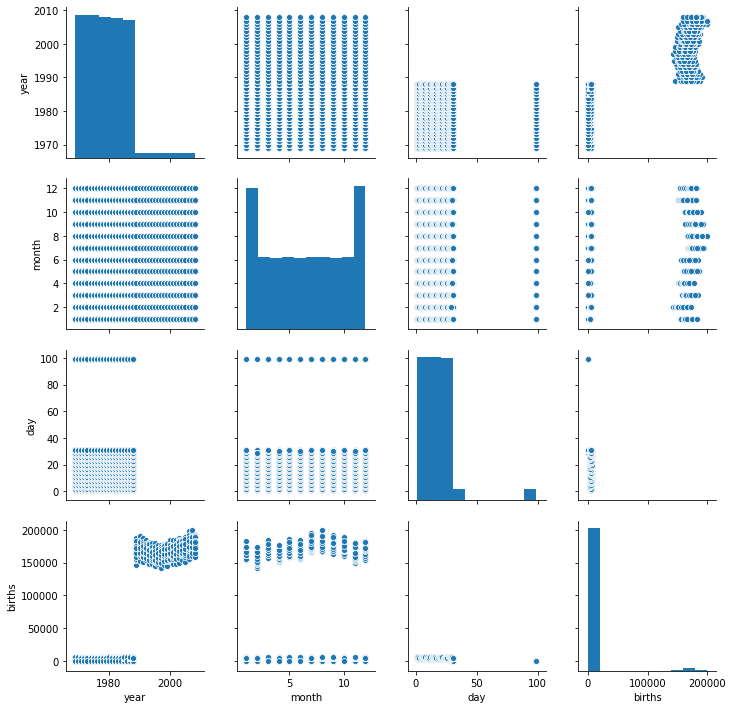

In [21]:
sns.pairplot(births)

In [22]:
births['decade'] = 10 * (births['year'] // 10)
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


We immediately see that male births outnumber female births in every decade.
To see this trend a bit more clearly, we can use the built-in plotting tools in Pandas to visualize the total number of births by year (see [Introduction to Matplotlib](04.00-Introduction-To-Matplotlib.ipynb) for a discussion of plotting with Matplotlib):

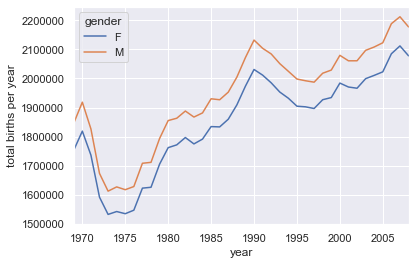

In [23]:
sns.set() # use Seaborn styles
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year');

With a simple pivot table and ``plot()`` method, we can immediately see the annual trend in births by gender. By eye, it appears that over the past 50 years male births have outnumbered female births by around 5%.

### Further data exploration

Though this doesn't necessarily relate to the pivot table, there are a few more interesting features we can pull out of this dataset using the Pandas tools covered up to this point.
We must start by cleaning the data a bit, removing outliers caused by mistyped dates (e.g., June 31st) or missing values (e.g., June 99th).
One easy way to remove these all at once is to cut outliers; we'll do this via a robust sigma-clipping operation:

In [24]:
births.isnull()

,year,month,day,gender,births,decade
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
15542,False,False,True,False,False,False
15543,False,False,True,False,False,False
15544,False,False,True,False,False,False
15545,False,False,True,False,False,False


In [25]:
quartiles = np.percentile(births['births'], [25, 50, 75])
quartiles

array([4358. , 4814. , 5289.5])

In [26]:
mu = quartiles[1]
mu

4814.0

In [27]:
sig = 0.74 * (quartiles[1] - quartiles[0])
sig

337.44

This final line is a robust estimate of the sample mean, where the 0.74 comes from the interquartile range of a Gaussian distribution (You can learn more about sigma-clipping operations in a book I coauthored with Željko Ivezić, Andrew J. Connolly, and Alexander Gray: ["Statistics, Data Mining, and Machine Learning in Astronomy"](http://press.princeton.edu/titles/10159.html) (Princeton University Press, 2014)).

With this we can use the ``query()`` method (discussed further in [High-Performance Pandas: ``eval()`` and ``query()``](03.12-Performance-Eval-and-Query.ipynb)) to filter-out rows with births outside these values:

In [28]:
births = births.query('(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)')
births.head()

,year,month,day,gender,births,decade
0,1969,1,1.0,F,4046,1960
1,1969,1,1.0,M,4440,1960
2,1969,1,2.0,F,4454,1960
3,1969,1,2.0,M,4548,1960
4,1969,1,3.0,F,4548,1960


Next we set the ``day`` column to integers; previously it had been a string because some columns in the dataset contained the value ``'null'``:

In [29]:
# set 'day' column to integer; it originally was a string due to nulls
births['day'] = births['day'].astype(int)

c:\users\kumar\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Finally, we can combine the day, month, and year to create a Date index (see [Working with Time Series](03.11-Working-with-Time-Series.ipynb)).
This allows us to quickly compute the weekday corresponding to each row:

In [30]:
## create a datetime index from the year, month, day
births.index = pd.to_datetime(10000 * births.year +
                              100 * births.month +
                              births.day, format='%Y%m%d')

births['dayofweek'] = births.index.dayofweek
births.head()

c:\users\kumar\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,month,day,gender,births,decade,dayofweek
1969-01-01,1969,1,1,F,4046,1960,2
1969-01-01,1969,1,1,M,4440,1960,2
1969-01-02,1969,1,2,F,4454,1960,3
1969-01-02,1969,1,2,M,4548,1960,3
1969-01-03,1969,1,3,F,4548,1960,4


Using this we can plot births by weekday for several decades:

,year,month,day,gender,births,decade,dayofweek
1969-01-01,1969,1,1,F,4046,1960,2
1969-01-01,1969,1,1,M,4440,1960,2
1969-01-02,1969,1,2,F,4454,1960,3
1969-01-02,1969,1,2,M,4548,1960,3
1969-01-03,1969,1,3,F,4548,1960,4


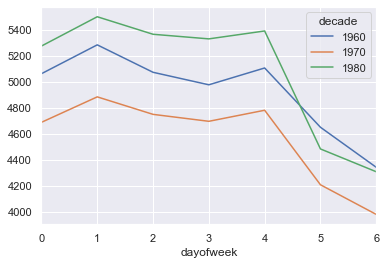

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl

births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
births.head()

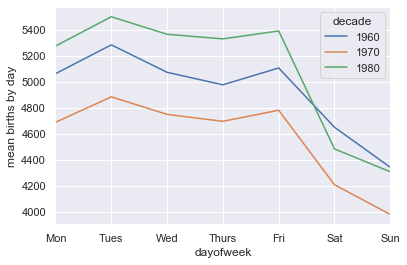

In [32]:
births.pivot_table('births', index='dayofweek',
                    columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day');

Apparently births are slightly less common on weekends than on weekdays! Note that the 1990s and 2000s are missing because the CDC data contains only the month of birth starting in 1989.

Another intersting view is to plot the mean number of births by the day of the *year*.
Let's first group the data by month and day separately:

In [50]:
births_by_date = births.pivot_table('births', 
                                    [births.index.month, births.index.day])
births_by_date

births
1  1   4009.225
   2   4247.400
   3   4500.900
   4   4571.350
   5   4603.625
...         ...
12 27  4850.150
   28  5044.200
   29  5120.150
   30  5172.350
   31  4859.200

[366 rows x 1 columns]

The result is a multi-index over months and days.
To make this easily plottable, let's turn these months and days into a date by associating them with a dummy year variable (making sure to choose a leap year so February 29th is correctly handled!)

In [47]:
births_by_date.index = [pd.datetime(2012, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

,births
2012-01-01,4009.225
2012-01-02,4247.400
2012-01-03,4500.900
2012-01-04,4571.350
2012-01-05,4603.625


Focusing on the month and day only, we now have a time series reflecting the average number of births by date of the year.
From this, we can use the ``plot`` method to plot the data. It reveals some interesting trends:

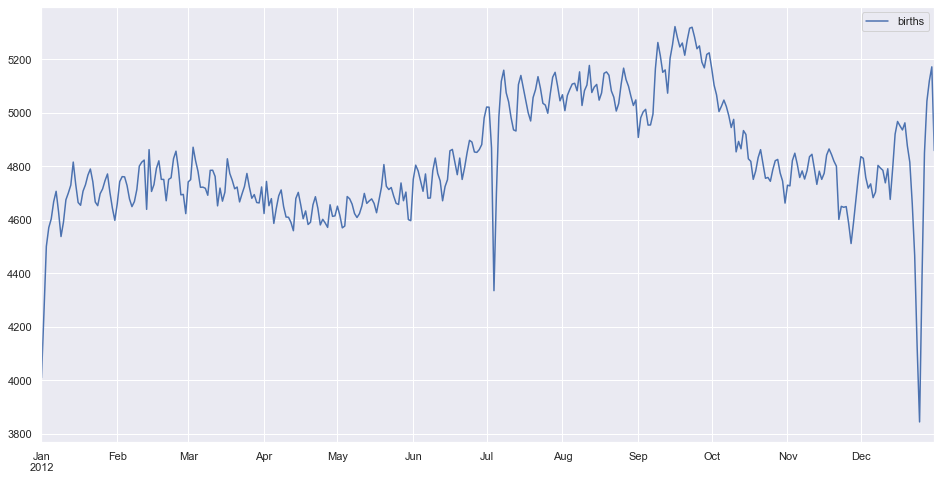

In [48]:
# Plot the results
fig, ax = plt.subplots(figsize=(16, 8))
births_by_date.plot(ax=ax);

In [51]:
births_by_date.index = [pd.datetime(2000, month, day)
                        for (month, day) in births_by_date.index]
births_by_date.head()

,births
2000-01-01,4009.225
2000-01-02,4247.400
2000-01-03,4500.900
2000-01-04,4571.350
2000-01-05,4603.625


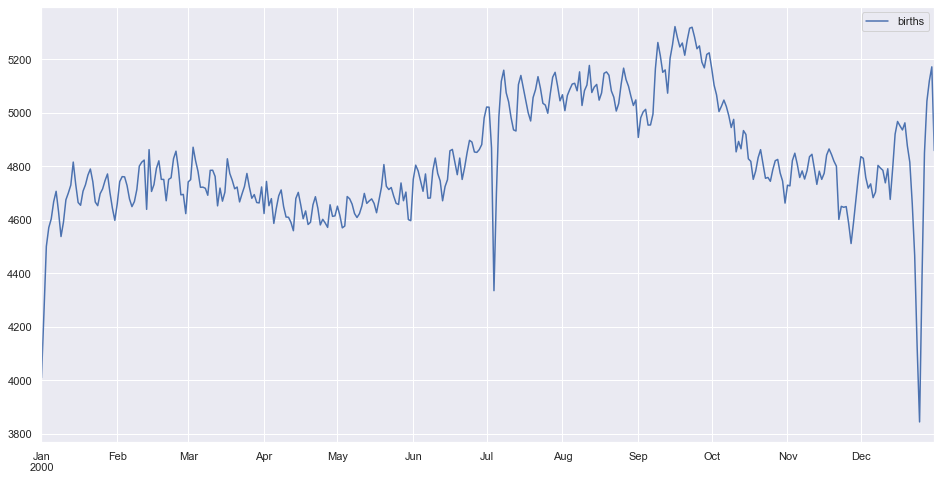

In [54]:
fig, ax = plt.subplots(figsize=(16, 8))
births_by_date.plot(ax=ax)

In particular, the striking feature of this graph is the dip in birthrate on US holidays (e.g., Independence Day, Labor Day, Thanksgiving, Christmas, New Year's Day) although this likely reflects trends in scheduled/induced births rather than some deep psychosomatic effect on natural births.
For more discussion on this trend, see the analysis and links in [Andrew Gelman's blog post](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/) on the subject.
We'll return to this figure in [Example:-Effect-of-Holidays-on-US-Births](04.09-Text-and-Annotation.ipynb#Example:-Effect-of-Holidays-on-US-Births), where we will use Matplotlib's tools to annotate this plot.

Looking at this short example, you can see that many of the Python and Pandas tools we've seen to this point can be combined and used to gain insight from a variety of datasets.
We will see some more sophisticated applications of these data manipulations in future sections!

<!--NAVIGATION-->
< [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb) | [Contents](Index.ipynb) | [Vectorized String Operations](03.10-Working-With-Strings.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.09-Pivot-Tables.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
